# Generative Adversarial Networks - A Tutorial
***
## 1. Introduction

This is an introduction to [Generative Adversarial Networks (GANs)](https://arxiv.org/abs/1406.2661) and how they can be used to generate photos of handwritten digits. In particular, we will use a an architecture that is is similar to the [DCGAN](https://arxiv.org/abs/1511.06434) proposed by Radford et al.

### 1.1 Core Idea
***
![Core Idea of GANS](GAN_Intro.jpeg)
<sub>Image Source: https://deeplearning4j.org/generative-adversarial-network</sub>

The core idea of GANs is to combine two neural networks with distinct tasks: a **generator** and a **descriminator**. The first tries to produce realistic images from random noise, while the latter tries to distinguish the generated images from the *real* images. The following analogy is taken from Goodfellow et al.'s [original paper on GANs](https://arxiv.org/abs/1406.2661):

> The generative model can be thought of as analogous to a team of counterfeiters, trying to produce fake currency and use it without detection, while the discriminative model is analogous to the police, trying to detect the counterfeit currency. Competition in this game drives both teams to improve their methods until the counterfeits are indistiguishable from the genuine articles.

### 1.2 Idea of this notebook
***
In this notebook, I just wanted to present a simple and straightforward implementation of GANs and how they can be used in practice. If you have any question, suggestions, etc., feel free to contact me!

In [3]:
import tensorflow as tf
import numpy as np
from numpy import genfromtxt
from matplotlib import pyplot as plt
import pickle

## 2. Generator Network
***
![DCGAN Architecture](DCGAN.jpeg)
<sub>Image Source: Original DCGAN paper (https://arxiv.org/abs/1511.06434) </sub>

The generator network takes random noise of a fixed dimension, e.g. 100, as input, and slowly scales this noise by transposed convolution layers from small but many *feature maps* to 3 (RGB) or 1 (Greyscale) large feature map which is the generated image. Usually, the noise vector z is drawn from a Gaussian with mean 0 and standard deviation of 1. The idea is that we assume that real images are also drawn from a distribution, and we want to get as close as possible to this distribution with our generator. (A standard way of measure the distance of two probability distributions is the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).)

Now, let's define the generator network. We adopt the findings from Radford et al. which mainly consists of 

1. Use Batch Normalisation
2. Use ReLU activation in the generator network, except for the last layer where one should use tanh
3. Only use transposed convolution operations instead of dense layers.

We go from a random noise vector of dimension 100 to 256 2x2 feature maps, and then slowly scale up to the final greyscale image of size (28,28). **Please note** that we do **not** use excactly the same dimensions of the figure above as we have to adjust it to a.) our computational power and b.) our final image size.

In [6]:
def generator(z, batch_size, z_dim=100, reuse=False):
    with tf.variable_scope("generator") as scope:
        if reuse:
            tf.get_variable_scope().reuse_variables()
        
        #Project and Reshape
        w_d1 = tf.get_variable('g_dw1', shape=[z_dim, 4*256], initializer=tf.initializers.truncated_normal(stddev=0.2))
        b_d1 = tf.get_variable('g_bw1', shape=[4*256], initializer=tf.initializers.zeros)
        z_reshape = tf.matmul(z, w_d1) + b_d1
        z_reshape = tf.nn.relu(z_reshape)
        z_reshape = tf.reshape(z_reshape, shape=[-1, 2, 2, 256])       
        # First Conv_transpose layer: From (2,2,265) to (4,4,64)
        w_convt_1 = tf.get_variable('g_conv1', shape=[5, 5, 64, 256], initializer=tf.initializers.truncated_normal(stddev=0.2))
        b_convt_1 = tf.get_variable('g_bconv1', shape=[64], initializer=tf.initializers.zeros)
        convt_1 = tf.nn.conv2d_transpose(z_reshape, filter=w_convt_1, output_shape=[batch_size, 4, 4, 64], strides=[1,2,2,1], padding='SAME')
        convt_1 = tf.contrib.layers.batch_norm(convt_1+b_convt_1, epsilon=1e-5, scope='bn1')
        convt_1 = tf.nn.relu(convt_1)
        # Second Conv_transpose layer: From (4,4,64) to (7,7,32)
        w_convt_2 = tf.get_variable('g_conv2', shape=[3, 3, 32, 64], initializer=tf.initializers.truncated_normal(stddev=0.2))
        b_convt_2 = tf.get_variable('g_bconv2', shape=[32], initializer=tf.initializers.zeros)
        convt_2 = tf.nn.conv2d_transpose(convt_1, filter=w_convt_2, output_shape=[batch_size, 7, 7, 32], strides=[1,2,2,1], padding='SAME')
        convt_2 = tf.contrib.layers.batch_norm(convt_2+b_convt_2, epsilon=1e-5, scope='bn2')
        convt_2 = tf.nn.relu(convt_2)
        # Third Conv_transpose layer From (7,7,32) to (14, 14, 16)
        w_convt_3 = tf.get_variable('g_conv3', shape=[5, 5, 16, 32], initializer=tf.initializers.truncated_normal(stddev=0.2))
        b_convt_3 = tf.get_variable('g_bconv3', shape=[16], initializer=tf.initializers.zeros)
        convt_3 = tf.nn.conv2d_transpose(convt_2, filter=w_convt_3, output_shape=[batch_size, 14, 14, 16], strides=[1,2,2,1], padding='SAME')
        convt_3 = tf.contrib.layers.batch_norm(convt_3+b_convt_3, epsilon=1e-5, scope='bn3')
        convt_3 = tf.nn.relu(convt_3)
        # Fourth Conv_transpose layer: From (14, 14, 16) to (28, 28, 1)
        w_convt_4 = tf.get_variable('g_conv4', shape=[5, 5, 1, 16], initializer=tf.initializers.truncated_normal(stddev=0.2))
        b_convt_4 = tf.get_variable('g_bconv4', shape=[1], initializer=tf.initializers.zeros)
        convt_4 = tf.nn.conv2d_transpose(convt_3, filter=w_convt_4, output_shape=[batch_size, 28, 28, 1], strides=[1,2,2,1], padding='SAME')
        convt_4 = tf.nn.tanh(convt_4)
        return convt_4

Let's define z as a placeholder and call the generator with it so that we can generate an example

In [ ]:
z_dimension = 100
z = tf.placeholder(dtype=tf.float32, shape=[None, z_dimension])
generated_img = generator(z, 1, z_dim=z_dimension)

### 2.1 Generator Network - Generating an example
***
We can now generate an example, however, it will just be random noise.

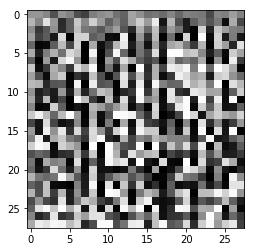

In [6]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    z_batch = np.random.normal(-1, 1, [1, z_dimension]) # Only one example in our batch
    feed_dict = {z: z_batch}
    img = session.run([generated_img], feed_dict=feed_dict)
    img = np.reshape(img, (28,28))
    plt.imshow(img, cmap='gray')
    plt.show()

## 3. Descriminator Network
***
![Discriminator](Discriminator.jpeg)
<sub>Image Source: https://hackernoon.com/how-do-gans-intuitively-work-2dda07f247a1a</sub>

Let's have a look at the descriminator network. It takes either the generated (fake) images or the real images as input and produces a probability how likely the input image is real. As a result, the output of this network is a single scalar between 0 and 1. We again adopt the findings of the Radford et al. so that we use 

1. batch normalisation
2. leakly-ReLU with coefficient 0.2
3. convolutional layers with strides to downsample (instead of dense layers).

Again, we use different dimensions from the figure above to meet our requirements. We only use one dense layer to get our final predicted probability. 

In [7]:
def descriminator(x, reuse=False):
    with tf.variable_scope("descriminator") as scope:
        if reuse:
            tf.get_variable_scope().reuse_variables()
        
        x_reshape = tf.reshape(x, shape=(-1, 28, 28, 1))

        # To 14,14
        w_conv1 = tf.get_variable('d_w1', shape=[5, 5, 1, 16], initializer=tf.initializers.truncated_normal(stddev=0.2))
        b_conv1 = tf.get_variable('d_b1', shape=[16], initializer=tf.initializers.zeros)
        conv_1 = tf.nn.conv2d(x_reshape, filter=w_conv1, strides=[1,2,2,1], padding='SAME')
        conv_1 = tf.contrib.layers.batch_norm(conv_1 + b_conv1, epsilon=1e-5, scope='dbn1')
        conv_1 = tf.nn.leaky_relu(conv_1)

        # To 7,7
        w_conv2 = tf.get_variable('d_w2', shape=[5, 5, 16, 32], initializer=tf.initializers.truncated_normal(stddev=0.2))
        b_conv2 = tf.get_variable('d_b2', shape=[32], initializer=tf.initializers.zeros)
        conv_2 = tf.nn.conv2d(conv_1, filter=w_conv2, strides=[1,2,2,1], padding='SAME')
        conv_2 = tf.contrib.layers.batch_norm(conv_2 + b_conv2, epsilon=1e-5, scope='dbn2')
        conv_2 = tf.nn.leaky_relu(conv_2)

        # To 4,4
        w_conv3 = tf.get_variable('d_w3', shape=[5, 5, 32, 64], initializer=tf.initializers.truncated_normal(stddev=0.2))
        b_conv3 = tf.get_variable('d_b3', shape=[64], initializer=tf.initializers.zeros)
        conv_3 = tf.nn.conv2d(conv_2, filter=w_conv3, strides=[1,2,2,1], padding='SAME')
        conv_3 = tf.contrib.layers.batch_norm(conv_3 + b_conv3, epsilon=1e-5, scope='dbn3')
        conv_3 = tf.nn.leaky_relu(conv_3)

        # To 1,1
        w_conv4 = tf.get_variable('d_w4', shape=[3, 3, 64, 128], initializer=tf.initializers.truncated_normal(stddev=0.2))
        b_conv4 = tf.get_variable('d_b4', shape=[128], initializer=tf.initializers.zeros)
        conv_4 = tf.nn.conv2d(conv_3, filter=w_conv4, strides=[1,2,2,1], padding='VALID')
        conv_4 = tf.contrib.layers.batch_norm(conv_4 + b_conv4, epsilon=1e-5, scope='dbn4')
        conv_4 = tf.nn.leaky_relu(conv_4)
        conv_4 = tf.reshape(conv_4, shape=[-1, 128])
        
        #Dense layer 128 to 1
        w_d1 = tf.get_variable('d_wd1', shape=[128, 1], initializer=tf.initializers.truncated_normal(stddev=0.2))
        b_d1 = tf.get_variable('d_db1', shape=[1], initializer=tf.initializers.zeros)
        out_p = tf.matmul(conv_4, w_d1) + b_d1
        return out_p

## 4. Loss Functions and Optimiser
***
### 4.1 Generator Loss
The aim of the generator network is to get a high probability value D(.) of the discriminator for its generated images G(z). Applying gradient descent, the generator descents according to the following minibatch gradient descent formula where m is the minibatch size:
![Generator Loss](loss_g.jpeg)
<sub>Image Source: [Original GAN Paper](https://arxiv.org/abs/1406.2661)</sub> 

### 4.2 Discriminator Loss
The discriminator combines two different loss functions. First, the probability values should be maximised for the real images, D(x), and second, the probability values should be minimised for the fake images, D(G(z)), or the complimentary value, 1 - D(G(z)), should be maximised. In the gradient descent framework, this means that we ascent according to the minibatch gradient ascent formula:
![Discriminator Loss](loss_d.jpeg)
<sub>Image Source: [Original GAN Paper](https://arxiv.org/abs/1406.2661)</sub> 

In tensorflow, we can use the function sigmoid_cross_entropy_with logits for all three cases. The reason is that a.) the sigmoid assures an output value between 0 and 1, and b.) the cross entropy loss is reduced to either log(1 - D(G(z)) (generator case), log(D(G(z)) (first discriminator case), or log(1 - D(x)) (second discriminator case) as we set p = 1 (1. and 3. case) or p = 0 (2. case) in the cross entropy formula. If this was too complicated, you might get a better understanding of loss functions in GANs [here](https://danieltakeshi.github.io/2017/03/05/understanding-generative-adversarial-networks/).

### 4.3 Optimiser
I implemented the Adam optimiser with a learning rate of 0.0002, as suggested by Redford et al. in the DCGAN paper. An interesting detail is that we have to define the variables we would like to optimise over, as we update the discriminator and generator in turns. This is why we used variables names starting with 'g_' or 'd_', respectively. 

In [4]:
tf.reset_default_graph() # To ensure that everything we did is deleted

batch_size = 128
z = tf.placeholder(dtype=tf.float32, shape=[None, z_dimension])
x = tf.placeholder(dtype=tf.float32, shape=[None, 784])
Gen_z = generator(z, batch_size, z_dim=z_dimension)
Des_gz = descriminator(Gen_z)
Des_x = descriminator(x, reuse=True)

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(Des_gz), logits=Des_gz))
d_loss1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(Des_gz), logits=Des_gz))
d_loss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(Des_x), logits=Des_x))
d_loss = d_loss1 + d_loss2

train_var = tf.trainable_variables()
g_var = [v for v in train_var if 'g_' in v.name]
d_var = [v for v in train_var if 'd_' in v.name]
#adam = tf.train.AdamOptimizer(learning_rate=0.0002)
g_optimiser = tf.train.AdamOptimizer(0.0002).minimize(g_loss, var_list=g_var)
d_optimiser = tf.train.AdamOptimizer(0.0002).minimize(-1*d_loss, var_list=d_var) # minimizing -1*d_loss is the same as maximizing d_loss

NameError: name 'z_dimension' is not defined

## 5. Train the GANs
***
Finally, we can train the GANs! The only thing we have to keep in mind is that we train the two networks in turns, and that we optimise over the approriate discriminator / generator weights only!

### 5.1 Import Data
First, we import the real images. I use the CSV file of the training images, however, you could also use the standard images. You can access the CSV version [here](https://pjreddie.com/projects/mnist-in-csv/), or the ordinary version [here](http://yann.lecun.com/exdb/mnist/). I save the array as a pickle file to ensure faster use later. **Its is important to note** that we need to rescale the data to the tanh range (last Generator activation function) which is -1 to 1. 

In [7]:
try:
    with open('train_data.p', 'rb') as f:
        train_data = pickle.load(f)
    print('Training data loaded from pickle file.')
except:
    train_d = genfromtxt('mnist_train.csv', delimiter=',')
    train_data = train_d[:, 1:]
    with open('train_data.p', 'wb') as f:
        pickle.dump(train_data, f)
    print('Training Data loaded and saved as pickle file.')


Training data loaded from pickle file.


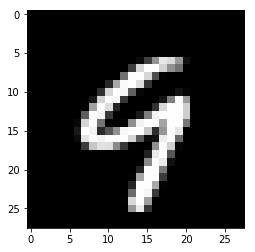

In [8]:
train_data = (train_data-128)/128 # Scale the data appropriately to -1-1
example_img = train_data[np.random.randint(0, len(train_data))].reshape((28,28))
plt.imshow(example_img, cmap='gray')
plt.show()

### 5.2 Training Loop
The training loop is very simple - we perform minibatch gradient descent with a batch size of 128 and 5000 iterations. We call the optimiser in every iteration, and log the losses in every 50th iteration

In [9]:
session = tf.Session()
train_data_l = len(train_data)
session.run(tf.global_variables_initializer())

for i in range(5000):
    batch_x = train_data[np.random.choice(train_data_l, size=batch_size, replace=False)]
    batch_z = np.random.normal(size=(batch_size, z_dimension))
    feed_dict = {x: batch_x, z: batch_z}
    _, dl = session.run([d_optimiser, d_loss], feed_dict=feed_dict)
    _, gl = session.run([g_optimiser, g_loss], feed_dict=feed_dict)
    if i%50 == 0:
        print('Generator loss (', i, 'Epoch) :', gl)
        print('Descriminator loss (', i, 'Epoch) :', dl)
    

Generator loss ( 0 Epoch) : 0.318075
Descriminator loss ( 0 Epoch) : 0.96885014
Generator loss ( 50 Epoch) : 0.3862914
Descriminator loss ( 50 Epoch) : 0.8206196
Generator loss ( 100 Epoch) : 0.48421746
Descriminator loss ( 100 Epoch) : 0.7498026
Generator loss ( 150 Epoch) : 0.5548833
Descriminator loss ( 150 Epoch) : 0.72193986
Generator loss ( 200 Epoch) : 0.6164018
Descriminator loss ( 200 Epoch) : 0.68479383
Generator loss ( 250 Epoch) : 0.66645753
Descriminator loss ( 250 Epoch) : 0.6480519
Generator loss ( 300 Epoch) : 0.69574845
Descriminator loss ( 300 Epoch) : 0.6316272
Generator loss ( 350 Epoch) : 0.7077548
Descriminator loss ( 350 Epoch) : 0.6401926
Generator loss ( 400 Epoch) : 0.71988857
Descriminator loss ( 400 Epoch) : 0.62801206
Generator loss ( 450 Epoch) : 0.7179626
Descriminator loss ( 450 Epoch) : 0.62822837
Generator loss ( 500 Epoch) : 0.7350515
Descriminator loss ( 500 Epoch) : 0.61061513
Generator loss ( 550 Epoch) : 0.73209584
Descriminator loss ( 550 Epoch) 

Generator loss ( 4750 Epoch) : 0.73169684
Descriminator loss ( 4750 Epoch) : 0.50117016
Generator loss ( 4800 Epoch) : 0.7420403
Descriminator loss ( 4800 Epoch) : 0.51410276
Generator loss ( 4850 Epoch) : 0.7362561
Descriminator loss ( 4850 Epoch) : 0.52090317
Generator loss ( 4900 Epoch) : 0.7381003
Descriminator loss ( 4900 Epoch) : 0.5031168
Generator loss ( 4950 Epoch) : 0.75159717
Descriminator loss ( 4950 Epoch) : 0.4770156


## 6. Results
Let's have a look at a random result!

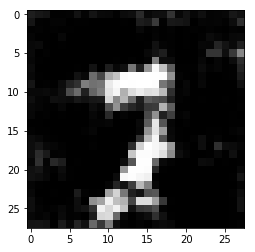

In [32]:
sample_img = generator(z,1,z_dim=z_dimension, reuse=True)
z_batch = np.random.normal(size=(1, z_dimension))
img = session.run([sample_img], feed_dict={z: z_batch})
img = np.reshape(img, (28,28))
plt.imshow(img, cmap='gray')
plt.show()

We can generate a 20x20 image of 20x20=400 example digits to get a better overview over the quality of our generated images!

In [44]:
final_img = np.zeros((560,560), dtype=np.uint8)
for i in range(20):
    for j in range(20):
        sample_img = generator(z,1,z_dim=z_dimension, reuse=True)
        z_batch = np.random.normal(size=(1, z_dimension))
        img = session.run([sample_img], feed_dict={z: z_batch})
        img = np.reshape(img, (28,28))
        img = (img*128+128).round().astype(np.uint8)
        final_img[i*28:(i+1)*28, j*28:(j+1)*28] = img

/home/mich/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # This is added back by InteractiveShellApp.init_path()


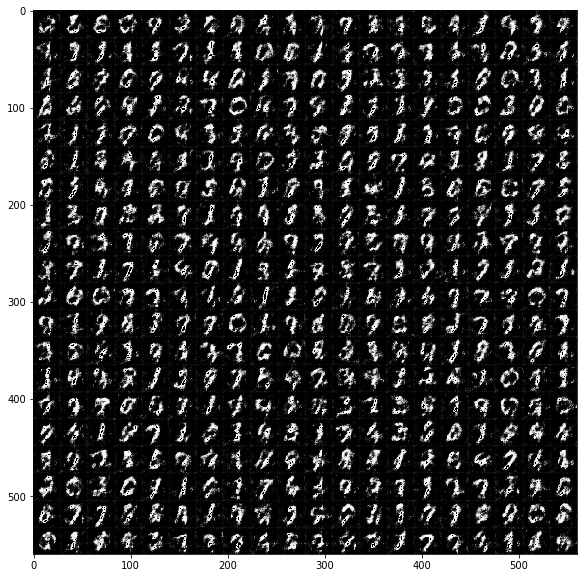

In [48]:
plt.figure(figsize=(10,10))
plt.imshow(final_img, cmap="gray")
plt.show()